# FALTA AJUSTAR ALGUMAS ONDAS. FAZER ISSO BUSCANDO O MELHOR AJUSTE POSSÍVEL. AINDA NÃO SABEMOS SE HÁ DUAS INTERFACES OU APENAS UMA. ANALISAR ISSO PELOS PLOTS. BASTA MUDAR OS LIMITES DAS LINHAS EM DOST_MIN E DIST_MAX. 



--- Analisando o arquivo: picks/n13 ---
Arquivo carregado com 100 pontos.
  -> Segmento 'Onda Direta': Velocidade = 533.01 m/s
  -> Segmento 'Refratada 1': Velocidade = 1587.54 m/s
  -> Segmento 'Refratada 2': Velocidade = 2007.08 m/s


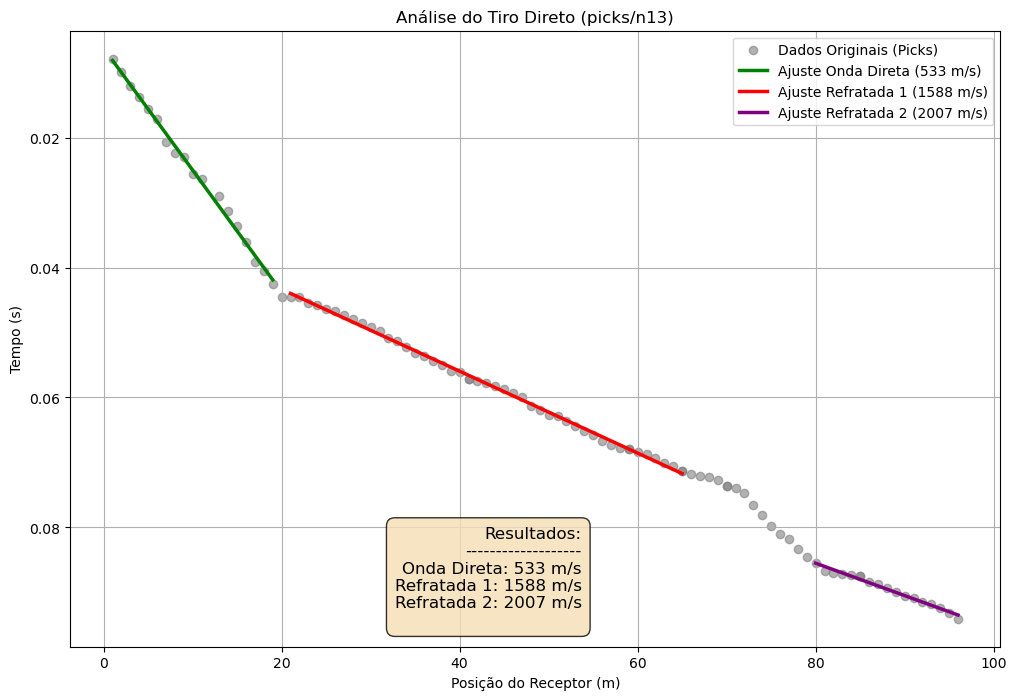


--- Analisando o arquivo: picks/n4 ---
Arquivo carregado com 96 pontos.
  -> Segmento 'Onda Direta': Velocidade = 371.01 m/s
  -> Segmento 'Refratada 1': Velocidade = 964.96 m/s
  -> Segmento 'Refratada 2': Velocidade = 1592.68 m/s


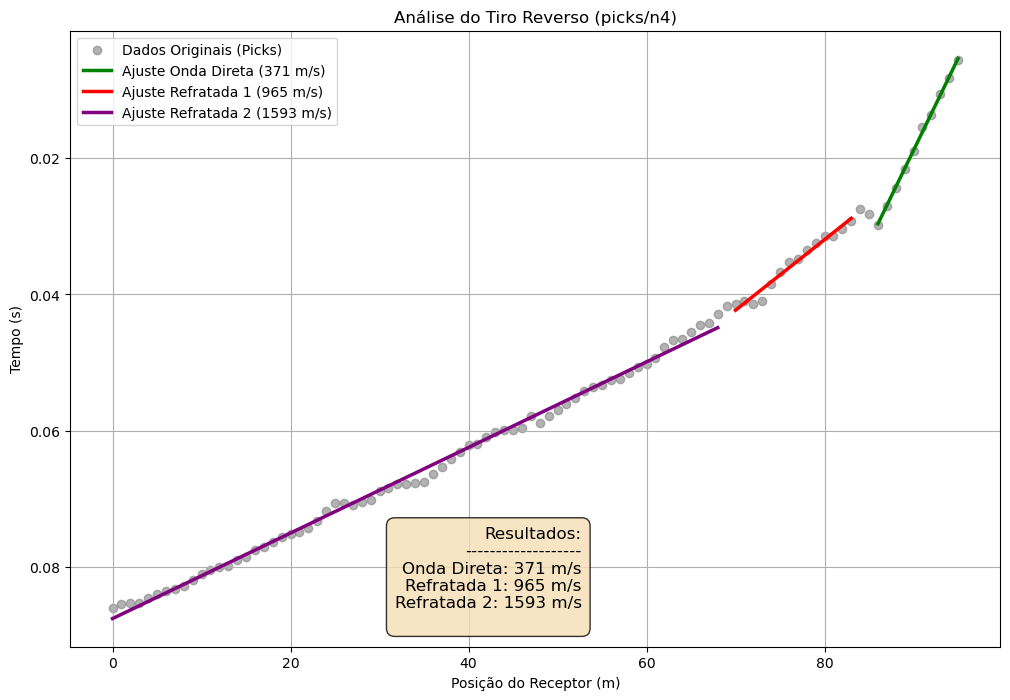


--- Unificando resultados para gerar os Modelos Geológicos ---

==> Velocidade V1 Média utilizada: 452.01 m/s
Tempo Recíproco (t_AB) estimado: 0.0940 s

--- Resultados da 1ª Interface ---

--- Resultados da 2ª Interface ---


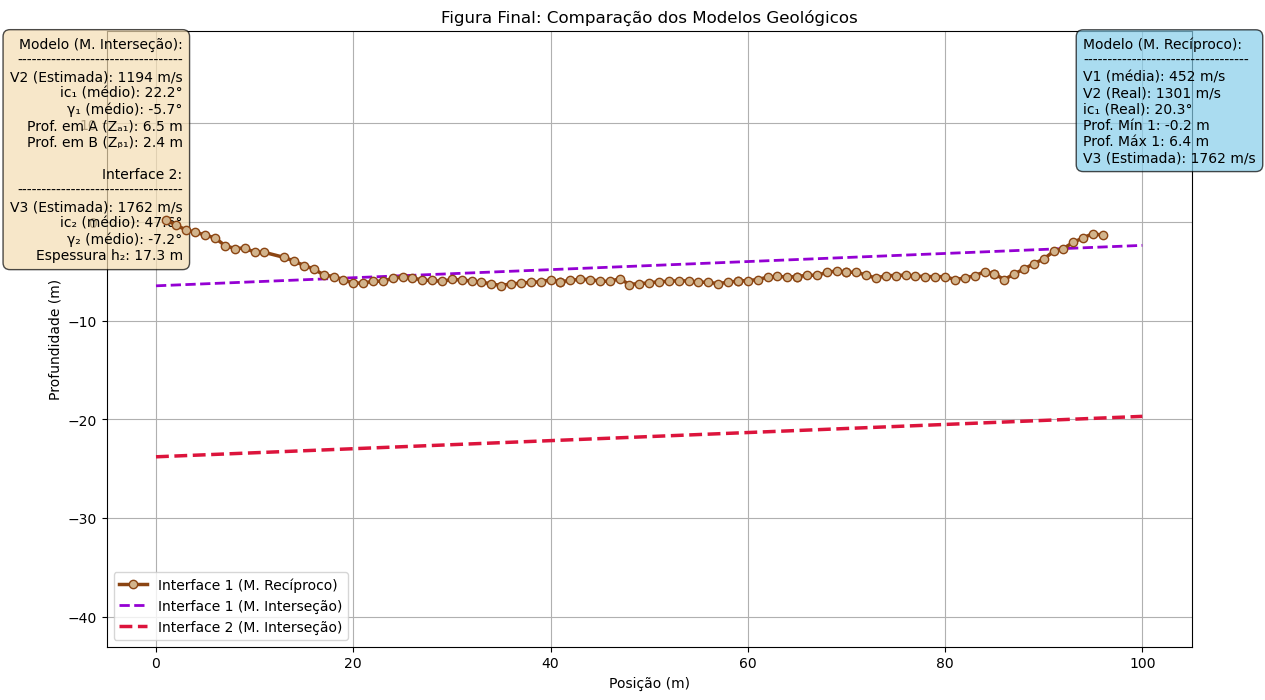

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Defina os parâmetros para o TIRO DIRETO
arquivo_direto = 'picks/n13'
segmentos_direto = {
    "Onda Direta": { "dist_min": 0, "dist_max": 19, "cor": "green" },
    "Refratada 1": { "dist_min": 21, "dist_max": 65, "cor": "red" },
    "Refratada 2": { "dist_min": 80, "dist_max": 99999, "cor": "purple" }
}

# 2. Defina os parâmetros para o TIRO REVERSO
arquivo_reverso = 'picks/n4'
segmentos_reverso = {
    "Onda Direta": { "dist_min": 86, "dist_max": 99999, "cor": "green" },
    "Refratada 1": { "dist_min": 70, "dist_max": 83, "cor": "red" },
    "Refratada 2": { "dist_min": 0, "dist_max": 68, "cor": "purple" }
    
}

# 3. Informe a distância total entre os dois pontos de tiro (em metros)
distancia_total_AB = 100.0

# ==============================================================================

# (A função 'analisar_tiro' permanece a mesma)
def analisar_tiro(nome_do_arquivo, segmentos_para_analise, titulo_grafico):
    print(f"\n--- Analisando o arquivo: {nome_do_arquivo} ---")
    try:
        tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
    except Exception as e:
        print(f"ERRO ao carregar o arquivo: {e}")
        return None, None, None, None
    indices_sorted = np.argsort(posicoes_brutas)
    posicoes = posicoes_brutas[indices_sorted]
    tempos = tempos_brutos[indices_sorted]
    print(f"Arquivo carregado com {len(posicoes)} pontos.")
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.scatter(posicoes, tempos, label='Dados Originais (Picks)', marker='o', alpha=0.6, c='gray')
    resultados_velocidade = {}
    resultados_intercepto = {}
    for nome, limites in segmentos_para_analise.items():
        mascara = (posicoes >= limites['dist_min']) & (posicoes <= limites['dist_max'])
        pos_segmento, t_segmento = posicoes[mascara], tempos[mascara]
        if len(pos_segmento) < 2:
            print(f"AVISO: Segmento '{nome}' tem pontos insuficientes.")
            continue
        inclinacao, intercepto = np.polyfit(pos_segmento, t_segmento, 1)
        velocidade = abs(1 / inclinacao)
        resultados_velocidade[nome] = velocidade
        resultados_intercepto[nome] = intercepto
        print(f"  -> Segmento '{nome}': Velocidade = {velocidade:.2f} m/s")
        ax.plot(pos_segmento, inclinacao * pos_segmento + intercepto, '-', color=limites['cor'], lw=2.5, 
                label=f'Ajuste {nome} ({velocidade:.0f} m/s)')
    texto_resultados = "Resultados:\n-------------------\n"
    for nome, vel in resultados_velocidade.items():
        texto_resultados += f"{nome}: {vel:.0f} m/s\n"
    ax.text(0.55, 0.03, texto_resultados, transform=ax.transAxes, fontsize=12, 
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))
    ax.set_xlabel('Posição do Receptor (m)')
    ax.set_ylabel('Tempo (s)')
    ax.set_title(titulo_grafico)
    ax.legend()
    ax.grid(True)
    ax.invert_yaxis()
    plt.show()
    return posicoes, tempos, resultados_velocidade, resultados_intercepto

# --- ANÁLISE DOS TIROS SEPARADAMENTE ---
pos_direto, t_direto, vel_direto, int_direto = analisar_tiro(arquivo_direto, segmentos_direto, f"Análise do Tiro Direto ({arquivo_direto})")
pos_reverso, t_reverso, vel_reverso, int_reverso = analisar_tiro(arquivo_reverso, segmentos_reverso, f"Análise do Tiro Reverso ({arquivo_reverso})")


# --- MODELO GEOLÓGICO (JUNÇÃO DOS RESULTADOS) ---
if vel_direto is not None and vel_reverso is not None:
    print("\n--- Unificando resultados para gerar os Modelos Geológicos ---")
    
    v1_direta = vel_direto.get("Onda Direta", 0)
    v1_reversa = vel_reverso.get("Onda Direta", 0)
    v1 = (v1_direta + v1_reversa) / 2
    print(f"\n==> Velocidade V1 Média utilizada: {v1:.2f} m/s")

    vd1 = vel_direto.get("Refratada 1", 0)
    vu1 = vel_reverso.get("Refratada 1", 0)
    tid1 = int_direto.get("Refratada 1", 0)
    
    mascara_refratada_rev1 = (pos_reverso >= segmentos_reverso['Refratada 1']['dist_min']) & (pos_reverso <= segmentos_reverso['Refratada 1']['dist_max'])
    pos_refratada_rev1 = pos_reverso[mascara_refratada_rev1]
    t_refratada_rev1 = t_reverso[mascara_refratada_rev1]
    _, tiu1 = np.polyfit(distancia_total_AB - pos_refratada_rev1, t_refratada_rev1, 1)

    tempo_reciproco_AB = np.interp(distancia_total_AB, pos_direto, t_direto)
    print(f"Tempo Recíproco (t_AB) estimado: {tempo_reciproco_AB:.4f} s")

    if "Refratada 2" in vel_direto and "Refratada 2" in vel_reverso:
        is_3_layers = True
        vd2 = vel_direto.get("Refratada 2", 0)
        vu2 = vel_reverso.get("Refratada 2", 0)
    else:
        is_3_layers = False

    print("\n--- Resultados da 1ª Interface ---")
    ic1_rad = 0.5 * (np.arcsin(v1/vd1) + np.arcsin(v1/vu1))
    gama1_rad = 0.5 * (np.arcsin(v1/vd1) - np.arcsin(v1/vu1))
    v2_intersecao = v1 / np.sin(ic1_rad)
    h_A1_perp = (tid1 * v1 * np.cos(ic1_rad)) / 2
    h_B1_perp = (tiu1 * v1 * np.cos(ic1_rad)) / 2
    Z_A1 = h_A1_perp / np.cos(gama1_rad)
    Z_B1 = h_B1_perp / np.cos(gama1_rad)
    
    t_reverso_interp = np.interp(pos_direto, pos_reverso, t_reverso)
    t_v_menos1 = 0.5 * (t_direto - t_reverso_interp + tempo_reciproco_AB)
    incl_v2_real, _ = np.polyfit(pos_direto, t_v_menos1, 1)
    v2_real = 1 / incl_v2_real
    
    delay_time1 = 0.5 * (t_direto + t_reverso_interp - tempo_reciproco_AB)
    ic1_real_rad = np.arcsin(v1 / v2_real)
    h1x_perp = (delay_time1 * v1) / np.cos(ic1_real_rad)
    Z1x_vertical = h1x_perp / np.cos(gama1_rad)

    if is_3_layers:
        print("\n--- Resultados da 2ª Interface ---")
        ic2_rad = 0.5 * (np.arcsin(v2_real/vd2) + np.arcsin(v2_real/vu2))
        gama2_rad = 0.5 * (np.arcsin(v2_real/vd2) - np.arcsin(v2_real/vu2))
        v3_intersecao = v2_real / np.sin(ic2_rad)
        ti_d2 = int_direto.get("Refratada 2", 0)
        i13_rad = np.arcsin(v1/v3_intersecao)
        termo_h1 = (2 * Z_A1 * np.cos(i13_rad)) / v1
        h2_espessura = ( (ti_d2 - termo_h1) * v2_real ) / (2 * np.cos(ic2_rad))
        Z_A2 = Z_A1 + h2_espessura
        Z_B2 = Z_B1 + h2_espessura
    
    # --- Geração da FIGURA FINAL COMPARATIVA ---
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    ax.plot(pos_direto, -Z1x_vertical, 'o-', label='Interface 1 (M. Recíproco)', color='saddlebrown', mfc='tan', lw=2.5, zorder=10)
    ax.plot([0, distancia_total_AB], [-Z_A1, -Z_B1], '--', color='darkviolet', lw=2, label='Interface 1 (M. Interseção)')
    
    texto_reciproco = (
        f"Modelo (M. Recíproco):\n"
        f"----------------------------------\n"
        f"V1 (média): {v1:.0f} m/s\n"
        f"V2 (Real): {v2_real:.0f} m/s\n"
        f"ic₁ (Real): {np.degrees(ic1_real_rad):.1f}°\n"
        f"Prof. Mín 1: {np.min(Z1x_vertical):.1f} m\n"
        f"Prof. Máx 1: {np.max(Z1x_vertical):.1f} m"
    )
    texto_intersecao = (
        f"Modelo (M. Interseção):\n"
        f"----------------------------------\n"
        f"V2 (Estimada): {v2_intersecao:.0f} m/s\n"
        f"ic₁ (médio): {np.degrees(ic1_rad):.1f}°\n"
        f"γ₁ (médio): {np.degrees(gama1_rad):.1f}°\n"
        f"Prof. em A (Zₐ₁): {Z_A1:.1f} m\n"
        f"Prof. em B (Zᵦ₁): {Z_B1:.1f} m"
    )

    if is_3_layers:
        ax.plot([0, distancia_total_AB], [-Z_A2, -Z_B2], '--', color='crimson', lw=2.5, label='Interface 2 (M. Interseção)')
        texto_reciproco += f"\nV3 (Estimada): {v3_intersecao:.0f} m/s"
        texto_intersecao += (
            f"\n\nInterface 2:\n"
            f"----------------------------------\n"
            f"V3 (Estimada): {v3_intersecao:.0f} m/s\n"
            f"ic₂ (médio): {np.degrees(ic2_rad):.1f}°\n"
            f"γ₂ (médio): {np.degrees(gama2_rad):.1f}°\n"
            f"Espessura h₂: {h2_espessura:.1f} m"
        )
        
    ax.set_title('Figura Final: Comparação dos Modelos Geológicos')
    ax.text(0.90, 0.99, texto_reciproco, transform=ax.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='skyblue', alpha=0.7))
    ax.text(0.07, 0.99, texto_intersecao, transform=ax.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
    
    ax.set_xlabel('Posição (m)')
    ax.set_ylabel('Profundidade (m)')
    ax.legend(loc='lower left')
    ax.grid(True)
    ax.axis('equal')
    plt.savefig('interfaces_finais_comparativo.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("\nAnálise não pôde ser concluída pois um dos arquivos teve erro no ajuste.")


--- Analisando o arquivo: picks/picks-plots-files-2su-ref12v0.txt ---
Arquivo carregado com 22 pontos.
AVISO: Segmento 'Onda Direta' tem pontos insuficientes.
  -> Segmento 'Refratada 1': Velocidade = 1273.49 m/s
AVISO: Segmento 'Refratada 2' tem pontos insuficientes.


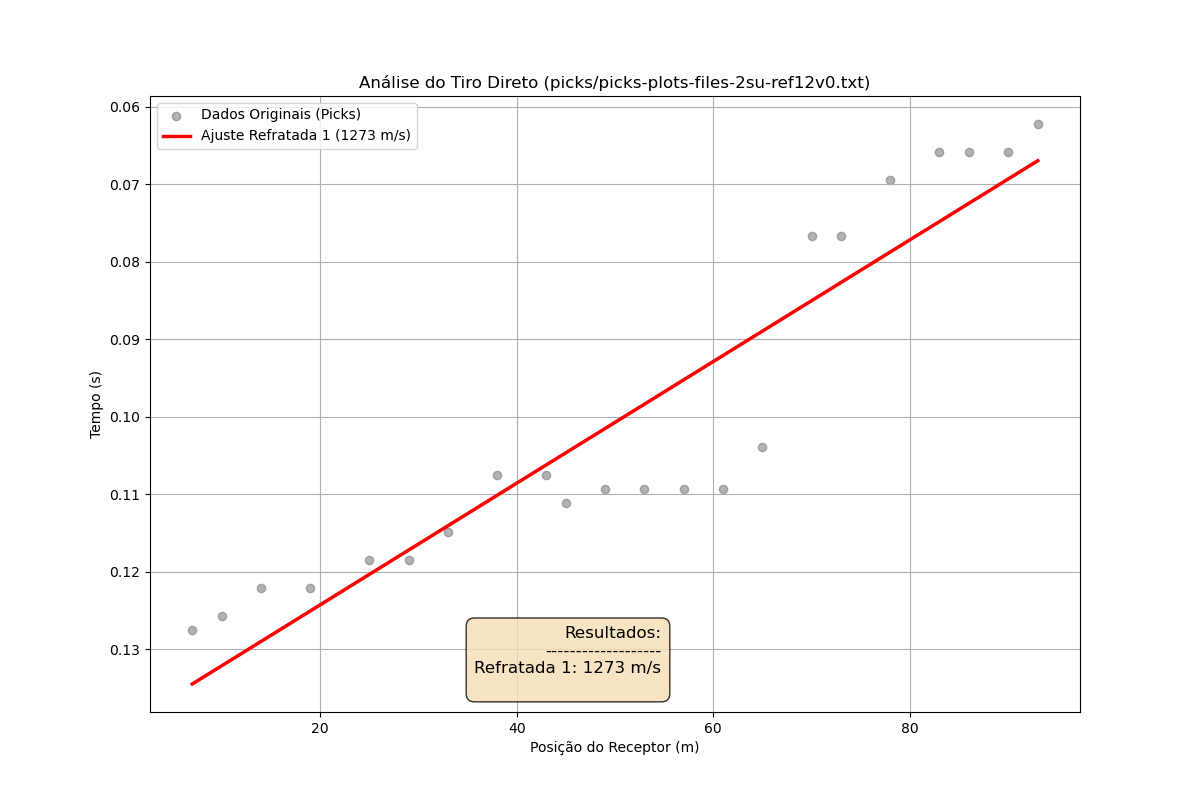


--- Analisando o arquivo: picks/picks-plots-files-2su-ref0.txt ---
Arquivo carregado com 15 pontos.
AVISO: Segmento 'Onda Direta' tem pontos insuficientes.
  -> Segmento 'Refratada 1': Velocidade = 3213.20 m/s
AVISO: Segmento 'Refratada 2' tem pontos insuficientes.


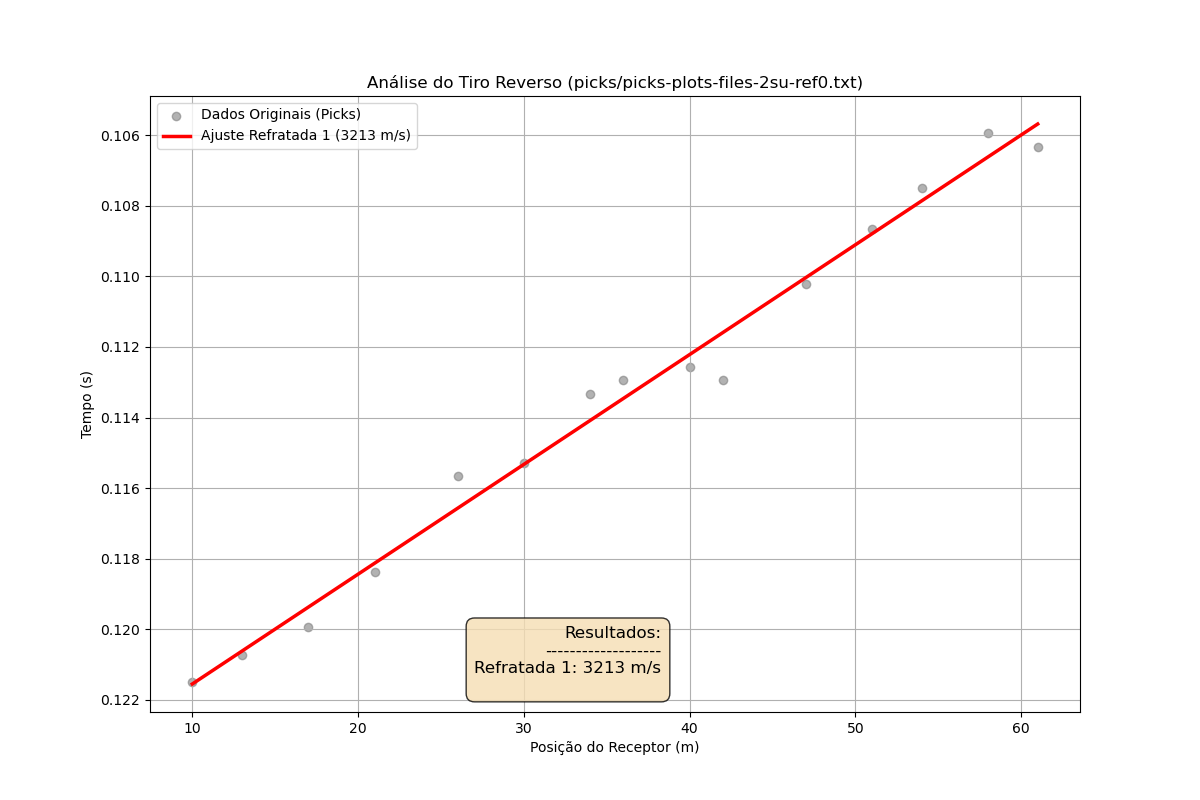


--- Unificando resultados para gerar os Modelos Geológicos ---

==> Velocidade V1 Média utilizada: 0.00 m/s
Tempo Recíproco (t_AB) estimado: 0.0622 s

--- Resultados da 1ª Interface ---


/tmp/ipykernel_33087/3403307558.py:111: RuntimeWarning: invalid value encountered in scalar divide
  v2_intersecao = v1 / np.sin(ic1_rad)


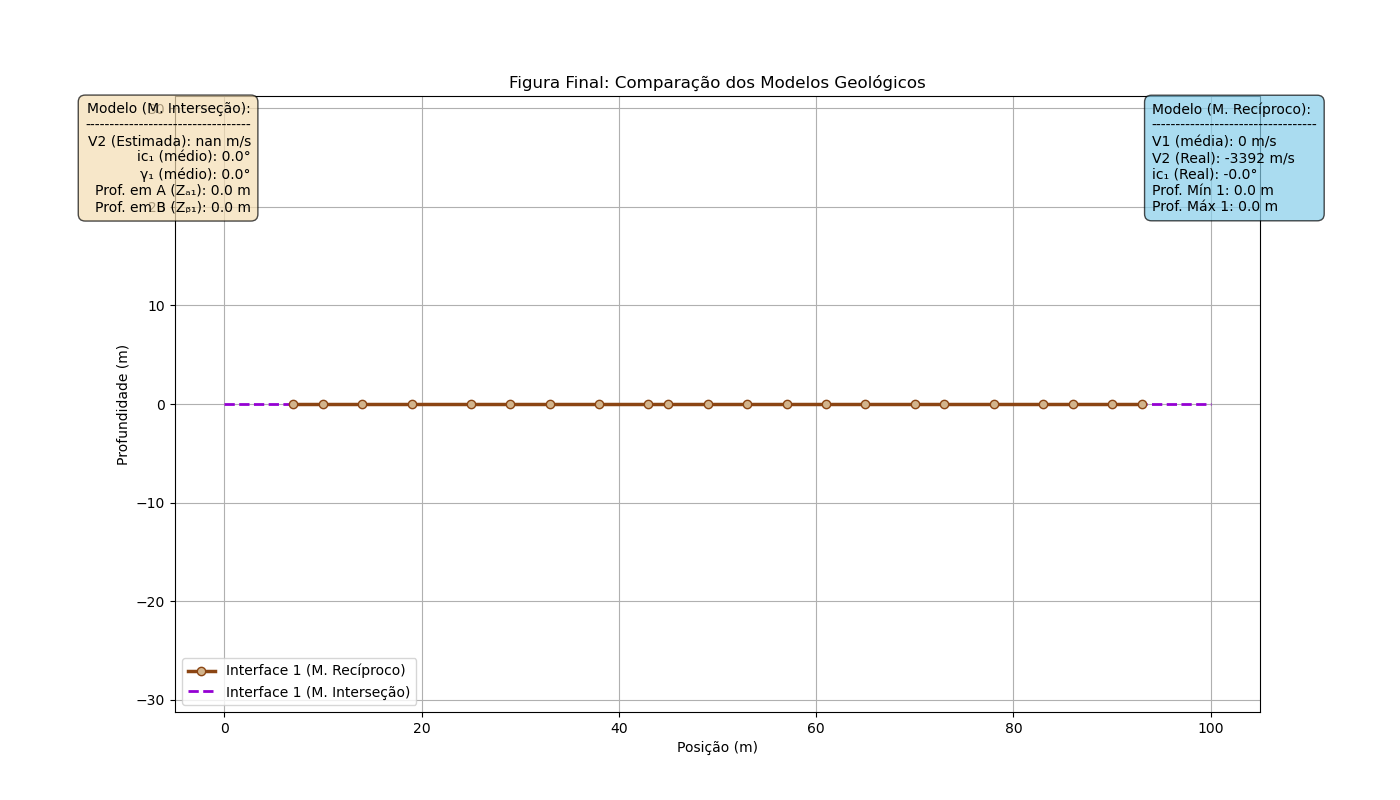

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Defina os parâmetros para o TIRO DIRETO
arquivo_direto = 'picks/picks-plots-files-2su-ref12v0.txt'
segmentos_direto = {
    "Onda Direta": { "dist_min": 0, "dist_max": 0, "cor": "green" },
    "Refratada 1": { "dist_min": 0, "dist_max": 999999, "cor": "red" },
    "Refratada 2": { "dist_min": 0, "dist_max": 0, "cor": "purple" }
}

# 2. Defina os parâmetros para o TIRO REVERSO
arquivo_reverso = 'picks/picks-plots-files-2su-ref0.txt'
segmentos_reverso = {
    "Onda Direta": { "dist_min": 0, "dist_max": 0, "cor": "green" },
    "Refratada 1": { "dist_min": 0, "dist_max": 999999, "cor": "red" },
    "Refratada 2": { "dist_min": 0, "dist_max": 0, "cor": "purple" }
    
}

# 3. Informe a distância total entre os dois pontos de tiro (em metros)
distancia_total_AB = 100.0

# ==============================================================================

# (A função 'analisar_tiro' permanece a mesma)
def analisar_tiro(nome_do_arquivo, segmentos_para_analise, titulo_grafico):
    print(f"\n--- Analisando o arquivo: {nome_do_arquivo} ---")
    try:
        tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
    except Exception as e:
        print(f"ERRO ao carregar o arquivo: {e}")
        return None, None, None, None
    indices_sorted = np.argsort(posicoes_brutas)
    posicoes = posicoes_brutas[indices_sorted]
    tempos = tempos_brutos[indices_sorted]
    print(f"Arquivo carregado com {len(posicoes)} pontos.")
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.scatter(posicoes, tempos, label='Dados Originais (Picks)', marker='o', alpha=0.6, c='gray')
    resultados_velocidade = {}
    resultados_intercepto = {}
    for nome, limites in segmentos_para_analise.items():
        mascara = (posicoes >= limites['dist_min']) & (posicoes <= limites['dist_max'])
        pos_segmento, t_segmento = posicoes[mascara], tempos[mascara]
        if len(pos_segmento) < 2:
            print(f"AVISO: Segmento '{nome}' tem pontos insuficientes.")
            continue
        inclinacao, intercepto = np.polyfit(pos_segmento, t_segmento, 1)
        velocidade = abs(1 / inclinacao)
        resultados_velocidade[nome] = velocidade
        resultados_intercepto[nome] = intercepto
        print(f"  -> Segmento '{nome}': Velocidade = {velocidade:.2f} m/s")
        ax.plot(pos_segmento, inclinacao * pos_segmento + intercepto, '-', color=limites['cor'], lw=2.5, 
                label=f'Ajuste {nome} ({velocidade:.0f} m/s)')
    texto_resultados = "Resultados:\n-------------------\n"
    for nome, vel in resultados_velocidade.items():
        texto_resultados += f"{nome}: {vel:.0f} m/s\n"
    ax.text(0.55, 0.03, texto_resultados, transform=ax.transAxes, fontsize=12, 
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))
    ax.set_xlabel('Posição do Receptor (m)')
    ax.set_ylabel('Tempo (s)')
    ax.set_title(titulo_grafico)
    ax.legend()
    ax.grid(True)
    ax.invert_yaxis()
    plt.show()
    return posicoes, tempos, resultados_velocidade, resultados_intercepto

# --- ANÁLISE DOS TIROS SEPARADAMENTE ---
pos_direto, t_direto, vel_direto, int_direto = analisar_tiro(arquivo_direto, segmentos_direto, f"Análise do Tiro Direto ({arquivo_direto})")
pos_reverso, t_reverso, vel_reverso, int_reverso = analisar_tiro(arquivo_reverso, segmentos_reverso, f"Análise do Tiro Reverso ({arquivo_reverso})")


# --- MODELO GEOLÓGICO (JUNÇÃO DOS RESULTADOS) ---
if vel_direto is not None and vel_reverso is not None:
    print("\n--- Unificando resultados para gerar os Modelos Geológicos ---")
    
    v1_direta = vel_direto.get("Onda Direta", 0)
    v1_reversa = vel_reverso.get("Onda Direta", 0)
    v1 = (v1_direta + v1_reversa) / 2
    print(f"\n==> Velocidade V1 Média utilizada: {v1:.2f} m/s")

    vd1 = vel_direto.get("Refratada 1", 0)
    vu1 = vel_reverso.get("Refratada 1", 0)
    tid1 = int_direto.get("Refratada 1", 0)
    
    mascara_refratada_rev1 = (pos_reverso >= segmentos_reverso['Refratada 1']['dist_min']) & (pos_reverso <= segmentos_reverso['Refratada 1']['dist_max'])
    pos_refratada_rev1 = pos_reverso[mascara_refratada_rev1]
    t_refratada_rev1 = t_reverso[mascara_refratada_rev1]
    _, tiu1 = np.polyfit(distancia_total_AB - pos_refratada_rev1, t_refratada_rev1, 1)

    tempo_reciproco_AB = np.interp(distancia_total_AB, pos_direto, t_direto)
    print(f"Tempo Recíproco (t_AB) estimado: {tempo_reciproco_AB:.4f} s")

    if "Refratada 2" in vel_direto and "Refratada 2" in vel_reverso:
        is_3_layers = True
        vd2 = vel_direto.get("Refratada 2", 0)
        vu2 = vel_reverso.get("Refratada 2", 0)
    else:
        is_3_layers = False

    print("\n--- Resultados da 1ª Interface ---")
    ic1_rad = 0.5 * (np.arcsin(v1/vd1) + np.arcsin(v1/vu1))
    gama1_rad = 0.5 * (np.arcsin(v1/vd1) - np.arcsin(v1/vu1))
    v2_intersecao = v1 / np.sin(ic1_rad)
    h_A1_perp = (tid1 * v1 * np.cos(ic1_rad)) / 2
    h_B1_perp = (tiu1 * v1 * np.cos(ic1_rad)) / 2
    Z_A1 = h_A1_perp / np.cos(gama1_rad)
    Z_B1 = h_B1_perp / np.cos(gama1_rad)
    
    t_reverso_interp = np.interp(pos_direto, pos_reverso, t_reverso)
    t_v_menos1 = 0.5 * (t_direto - t_reverso_interp + tempo_reciproco_AB)
    incl_v2_real, _ = np.polyfit(pos_direto, t_v_menos1, 1)
    v2_real = 1 / incl_v2_real
    
    delay_time1 = 0.5 * (t_direto + t_reverso_interp - tempo_reciproco_AB)
    ic1_real_rad = np.arcsin(v1 / v2_real)
    h1x_perp = (delay_time1 * v1) / np.cos(ic1_real_rad)
    Z1x_vertical = h1x_perp / np.cos(gama1_rad)

    if is_3_layers:
        print("\n--- Resultados da 2ª Interface ---")
        ic2_rad = 0.5 * (np.arcsin(v2_real/vd2) + np.arcsin(v2_real/vu2))
        gama2_rad = 0.5 * (np.arcsin(v2_real/vd2) - np.arcsin(v2_real/vu2))
        v3_intersecao = v2_real / np.sin(ic2_rad)
        ti_d2 = int_direto.get("Refratada 2", 0)
        i13_rad = np.arcsin(v1/v3_intersecao)
        termo_h1 = (2 * Z_A1 * np.cos(i13_rad)) / v1
        h2_espessura = ( (ti_d2 - termo_h1) * v2_real ) / (2 * np.cos(ic2_rad))
        Z_A2 = Z_A1 + h2_espessura
        Z_B2 = Z_B1 + h2_espessura
    
    # --- Geração da FIGURA FINAL COMPARATIVA ---
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    ax.plot(pos_direto, -Z1x_vertical, 'o-', label='Interface 1 (M. Recíproco)', color='saddlebrown', mfc='tan', lw=2.5, zorder=10)
    ax.plot([0, distancia_total_AB], [-Z_A1, -Z_B1], '--', color='darkviolet', lw=2, label='Interface 1 (M. Interseção)')
    
    texto_reciproco = (
        f"Modelo (M. Recíproco):\n"
        f"----------------------------------\n"
        f"V1 (média): {v1:.0f} m/s\n"
        f"V2 (Real): {v2_real:.0f} m/s\n"
        f"ic₁ (Real): {np.degrees(ic1_real_rad):.1f}°\n"
        f"Prof. Mín 1: {np.min(Z1x_vertical):.1f} m\n"
        f"Prof. Máx 1: {np.max(Z1x_vertical):.1f} m"
    )
    texto_intersecao = (
        f"Modelo (M. Interseção):\n"
        f"----------------------------------\n"
        f"V2 (Estimada): {v2_intersecao:.0f} m/s\n"
        f"ic₁ (médio): {np.degrees(ic1_rad):.1f}°\n"
        f"γ₁ (médio): {np.degrees(gama1_rad):.1f}°\n"
        f"Prof. em A (Zₐ₁): {Z_A1:.1f} m\n"
        f"Prof. em B (Zᵦ₁): {Z_B1:.1f} m"
    )

    if is_3_layers:
        ax.plot([0, distancia_total_AB], [-Z_A2, -Z_B2], '--', color='crimson', lw=2.5, label='Interface 2 (M. Interseção)')
        texto_reciproco += f"\nV3 (Estimada): {v3_intersecao:.0f} m/s"
        texto_intersecao += (
            f"\n\nInterface 2:\n"
            f"----------------------------------\n"
            f"V3 (Estimada): {v3_intersecao:.0f} m/s\n"
            f"ic₂ (médio): {np.degrees(ic2_rad):.1f}°\n"
            f"γ₂ (médio): {np.degrees(gama2_rad):.1f}°\n"
            f"Espessura h₂: {h2_espessura:.1f} m"
        )
        
    ax.set_title('Figura Final: Comparação dos Modelos Geológicos')
    ax.text(0.90, 0.99, texto_reciproco, transform=ax.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='skyblue', alpha=0.7))
    ax.text(0.07, 0.99, texto_intersecao, transform=ax.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
    
    ax.set_xlabel('Posição (m)')
    ax.set_ylabel('Profundidade (m)')
    ax.legend(loc='lower left')
    ax.grid(True)
    ax.axis('equal')
    plt.savefig('interfaces_finais_comparativo.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("\nAnálise não pôde ser concluída pois um dos arquivos teve erro no ajuste.")


--- Analisando o arquivo: picks/nu=12.txt ---
Arquivo carregado com 77 pontos.
  -> Segmento 'Onda Direta': Velocidade = 1526.60 m/s
  -> Segmento 'Refratada 1': Velocidade = 1564.57 m/s
AVISO: Segmento 'Refratada 2' tem pontos insuficientes.


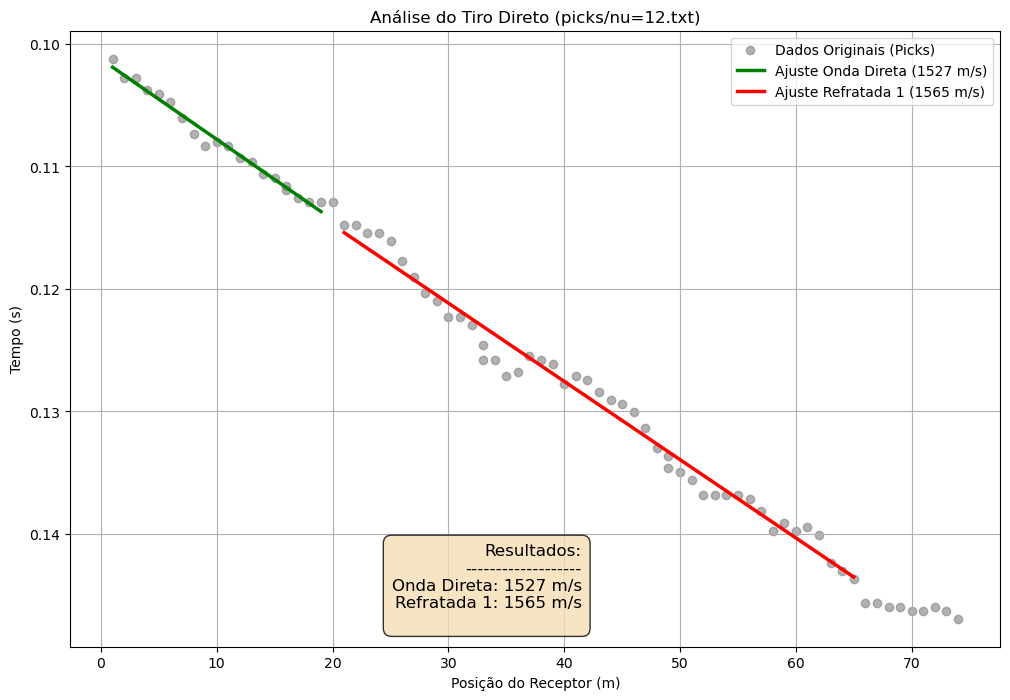


--- Analisando o arquivo: picks/n1 ---
Arquivo carregado com 97 pontos.
  -> Segmento 'Onda Direta': Velocidade = 4710.72 m/s
  -> Segmento 'Refratada 1': Velocidade = 4629.54 m/s
  -> Segmento 'Refratada 2': Velocidade = 2366.63 m/s


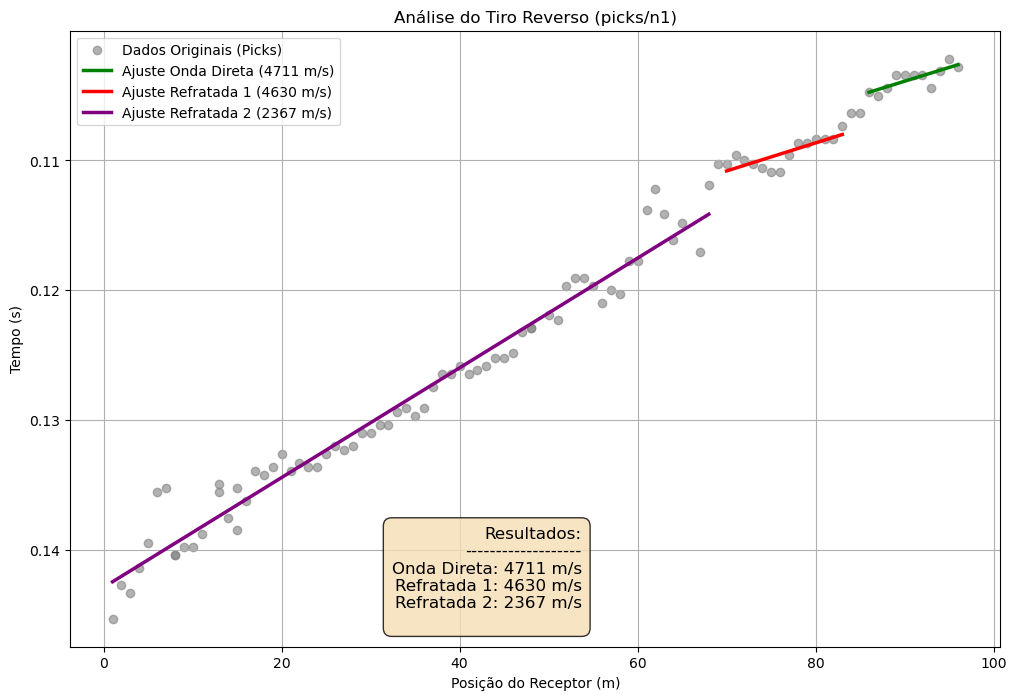


--- Unificando resultados para gerar os Modelos Geológicos ---

==> Velocidade V1 Média utilizada: 3118.66 m/s
Tempo Recíproco (t_AB) estimado: 0.1469 s

--- Resultados da 1ª Interface ---


/tmp/ipykernel_33087/508838900.py:109: RuntimeWarning: invalid value encountered in arcsin
  ic1_rad = 0.5 * (np.arcsin(v1/vd1) + np.arcsin(v1/vu1))
/tmp/ipykernel_33087/508838900.py:110: RuntimeWarning: invalid value encountered in arcsin
  gama1_rad = 0.5 * (np.arcsin(v1/vd1) - np.arcsin(v1/vu1))
/tmp/ipykernel_33087/508838900.py:123: RuntimeWarning: invalid value encountered in arcsin
  ic1_real_rad = np.arcsin(v1 / v2_real)


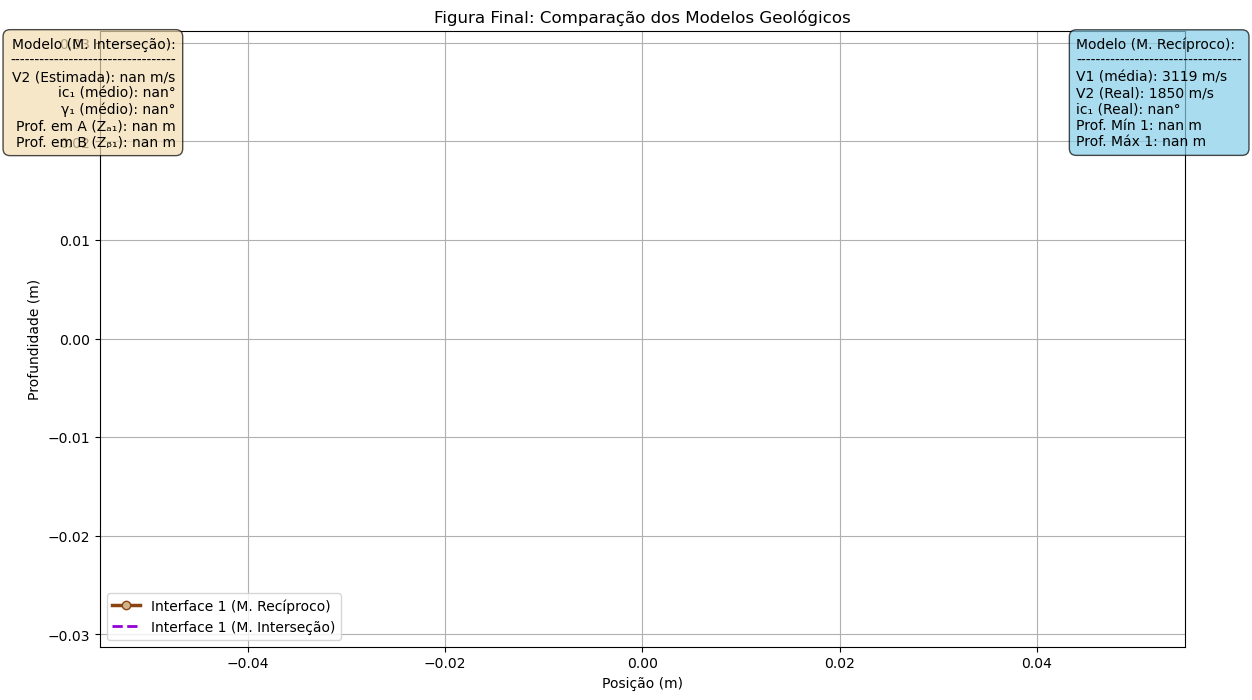

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Defina os parâmetros para o TIRO DIRETO
arquivo_direto = 'picks/nu=12.txt'
segmentos_direto = {
    "Onda Direta": { "dist_min": 0, "dist_max": 19, "cor": "green" },
    "Refratada 1": { "dist_min": 21, "dist_max": 65, "cor": "red" },
    "Refratada 2": { "dist_min": 80, "dist_max": 99999, "cor": "purple" }
}

# 2. Defina os parâmetros para o TIRO REVERSO
arquivo_reverso = 'picks/n1'
segmentos_reverso = {
    "Onda Direta": { "dist_min": 86, "dist_max": 99999, "cor": "green" },
    "Refratada 1": { "dist_min": 70, "dist_max": 83, "cor": "red" },
    "Refratada 2": { "dist_min": 0, "dist_max": 68, "cor": "purple" }
    
}

# 3. Informe a distância total entre os dois pontos de tiro (em metros)
distancia_total_AB = 100.0

# ==============================================================================

# (A função 'analisar_tiro' permanece a mesma)
def analisar_tiro(nome_do_arquivo, segmentos_para_analise, titulo_grafico):
    print(f"\n--- Analisando o arquivo: {nome_do_arquivo} ---")
    try:
        tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
    except Exception as e:
        print(f"ERRO ao carregar o arquivo: {e}")
        return None, None, None, None
    indices_sorted = np.argsort(posicoes_brutas)
    posicoes = posicoes_brutas[indices_sorted]
    tempos = tempos_brutos[indices_sorted]
    print(f"Arquivo carregado com {len(posicoes)} pontos.")
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.scatter(posicoes, tempos, label='Dados Originais (Picks)', marker='o', alpha=0.6, c='gray')
    resultados_velocidade = {}
    resultados_intercepto = {}
    for nome, limites in segmentos_para_analise.items():
        mascara = (posicoes >= limites['dist_min']) & (posicoes <= limites['dist_max'])
        pos_segmento, t_segmento = posicoes[mascara], tempos[mascara]
        if len(pos_segmento) < 2:
            print(f"AVISO: Segmento '{nome}' tem pontos insuficientes.")
            continue
        inclinacao, intercepto = np.polyfit(pos_segmento, t_segmento, 1)
        velocidade = abs(1 / inclinacao)
        resultados_velocidade[nome] = velocidade
        resultados_intercepto[nome] = intercepto
        print(f"  -> Segmento '{nome}': Velocidade = {velocidade:.2f} m/s")
        ax.plot(pos_segmento, inclinacao * pos_segmento + intercepto, '-', color=limites['cor'], lw=2.5, 
                label=f'Ajuste {nome} ({velocidade:.0f} m/s)')
    texto_resultados = "Resultados:\n-------------------\n"
    for nome, vel in resultados_velocidade.items():
        texto_resultados += f"{nome}: {vel:.0f} m/s\n"
    ax.text(0.55, 0.03, texto_resultados, transform=ax.transAxes, fontsize=12, 
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))
    ax.set_xlabel('Posição do Receptor (m)')
    ax.set_ylabel('Tempo (s)')
    ax.set_title(titulo_grafico)
    ax.legend()
    ax.grid(True)
    ax.invert_yaxis()
    plt.show()
    return posicoes, tempos, resultados_velocidade, resultados_intercepto

# --- ANÁLISE DOS TIROS SEPARADAMENTE ---
pos_direto, t_direto, vel_direto, int_direto = analisar_tiro(arquivo_direto, segmentos_direto, f"Análise do Tiro Direto ({arquivo_direto})")
pos_reverso, t_reverso, vel_reverso, int_reverso = analisar_tiro(arquivo_reverso, segmentos_reverso, f"Análise do Tiro Reverso ({arquivo_reverso})")


# --- MODELO GEOLÓGICO (JUNÇÃO DOS RESULTADOS) ---
if vel_direto is not None and vel_reverso is not None:
    print("\n--- Unificando resultados para gerar os Modelos Geológicos ---")
    
    v1_direta = vel_direto.get("Onda Direta", 0)
    v1_reversa = vel_reverso.get("Onda Direta", 0)
    v1 = (v1_direta + v1_reversa) / 2
    print(f"\n==> Velocidade V1 Média utilizada: {v1:.2f} m/s")

    vd1 = vel_direto.get("Refratada 1", 0)
    vu1 = vel_reverso.get("Refratada 1", 0)
    tid1 = int_direto.get("Refratada 1", 0)
    
    mascara_refratada_rev1 = (pos_reverso >= segmentos_reverso['Refratada 1']['dist_min']) & (pos_reverso <= segmentos_reverso['Refratada 1']['dist_max'])
    pos_refratada_rev1 = pos_reverso[mascara_refratada_rev1]
    t_refratada_rev1 = t_reverso[mascara_refratada_rev1]
    _, tiu1 = np.polyfit(distancia_total_AB - pos_refratada_rev1, t_refratada_rev1, 1)

    tempo_reciproco_AB = np.interp(distancia_total_AB, pos_direto, t_direto)
    print(f"Tempo Recíproco (t_AB) estimado: {tempo_reciproco_AB:.4f} s")

    if "Refratada 2" in vel_direto and "Refratada 2" in vel_reverso:
        is_3_layers = True
        vd2 = vel_direto.get("Refratada 2", 0)
        vu2 = vel_reverso.get("Refratada 2", 0)
    else:
        is_3_layers = False

    print("\n--- Resultados da 1ª Interface ---")
    ic1_rad = 0.5 * (np.arcsin(v1/vd1) + np.arcsin(v1/vu1))
    gama1_rad = 0.5 * (np.arcsin(v1/vd1) - np.arcsin(v1/vu1))
    v2_intersecao = v1 / np.sin(ic1_rad)
    h_A1_perp = (tid1 * v1 * np.cos(ic1_rad)) / 2
    h_B1_perp = (tiu1 * v1 * np.cos(ic1_rad)) / 2
    Z_A1 = h_A1_perp / np.cos(gama1_rad)
    Z_B1 = h_B1_perp / np.cos(gama1_rad)
    
    t_reverso_interp = np.interp(pos_direto, pos_reverso, t_reverso)
    t_v_menos1 = 0.5 * (t_direto - t_reverso_interp + tempo_reciproco_AB)
    incl_v2_real, _ = np.polyfit(pos_direto, t_v_menos1, 1)
    v2_real = 1 / incl_v2_real
    
    delay_time1 = 0.5 * (t_direto + t_reverso_interp - tempo_reciproco_AB)
    ic1_real_rad = np.arcsin(v1 / v2_real)
    h1x_perp = (delay_time1 * v1) / np.cos(ic1_real_rad)
    Z1x_vertical = h1x_perp / np.cos(gama1_rad)

    if is_3_layers:
        print("\n--- Resultados da 2ª Interface ---")
        ic2_rad = 0.5 * (np.arcsin(v2_real/vd2) + np.arcsin(v2_real/vu2))
        gama2_rad = 0.5 * (np.arcsin(v2_real/vd2) - np.arcsin(v2_real/vu2))
        v3_intersecao = v2_real / np.sin(ic2_rad)
        ti_d2 = int_direto.get("Refratada 2", 0)
        i13_rad = np.arcsin(v1/v3_intersecao)
        termo_h1 = (2 * Z_A1 * np.cos(i13_rad)) / v1
        h2_espessura = ( (ti_d2 - termo_h1) * v2_real ) / (2 * np.cos(ic2_rad))
        Z_A2 = Z_A1 + h2_espessura
        Z_B2 = Z_B1 + h2_espessura
    
    # --- Geração da FIGURA FINAL COMPARATIVA ---
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    ax.plot(pos_direto, -Z1x_vertical, 'o-', label='Interface 1 (M. Recíproco)', color='saddlebrown', mfc='tan', lw=2.5, zorder=10)
    ax.plot([0, distancia_total_AB], [-Z_A1, -Z_B1], '--', color='darkviolet', lw=2, label='Interface 1 (M. Interseção)')
    
    texto_reciproco = (
        f"Modelo (M. Recíproco):\n"
        f"----------------------------------\n"
        f"V1 (média): {v1:.0f} m/s\n"
        f"V2 (Real): {v2_real:.0f} m/s\n"
        f"ic₁ (Real): {np.degrees(ic1_real_rad):.1f}°\n"
        f"Prof. Mín 1: {np.min(Z1x_vertical):.1f} m\n"
        f"Prof. Máx 1: {np.max(Z1x_vertical):.1f} m"
    )
    texto_intersecao = (
        f"Modelo (M. Interseção):\n"
        f"----------------------------------\n"
        f"V2 (Estimada): {v2_intersecao:.0f} m/s\n"
        f"ic₁ (médio): {np.degrees(ic1_rad):.1f}°\n"
        f"γ₁ (médio): {np.degrees(gama1_rad):.1f}°\n"
        f"Prof. em A (Zₐ₁): {Z_A1:.1f} m\n"
        f"Prof. em B (Zᵦ₁): {Z_B1:.1f} m"
    )

    if is_3_layers:
        ax.plot([0, distancia_total_AB], [-Z_A2, -Z_B2], '--', color='crimson', lw=2.5, label='Interface 2 (M. Interseção)')
        texto_reciproco += f"\nV3 (Estimada): {v3_intersecao:.0f} m/s"
        texto_intersecao += (
            f"\n\nInterface 2:\n"
            f"----------------------------------\n"
            f"V3 (Estimada): {v3_intersecao:.0f} m/s\n"
            f"ic₂ (médio): {np.degrees(ic2_rad):.1f}°\n"
            f"γ₂ (médio): {np.degrees(gama2_rad):.1f}°\n"
            f"Espessura h₂: {h2_espessura:.1f} m"
        )
        
    ax.set_title('Figura Final: Comparação dos Modelos Geológicos')
    ax.text(0.90, 0.99, texto_reciproco, transform=ax.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='skyblue', alpha=0.7))
    ax.text(0.07, 0.99, texto_intersecao, transform=ax.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
    
    ax.set_xlabel('Posição (m)')
    ax.set_ylabel('Profundidade (m)')
    ax.legend(loc='lower left')
    ax.grid(True)
    ax.axis('equal')
    plt.savefig('interfaces_finais_comparativo.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("\nAnálise não pôde ser concluída pois um dos arquivos teve erro no ajuste.")

--- Iniciando Análise Comparativa de Tiros ---

--- Analisando o 'n4': picks/n4 ---
  -> Segmento 'Onda Direta': Velocidade = 371.01 m/s
  -> Segmento 'Refratada 1': Velocidade = 1221.26 m/s
  -> Segmento 'Refratada 2': Velocidade = 1533.12 m/s

--- Analisando o 'n1': picks/n1 ---
AVISO: Segmento 'Onda Direta' do 'n1' tem pontos insuficientes.
  -> Segmento 'Refratada 1': Velocidade = 2303.56 m/s

Gráfico comparativo salvo como: analise_comparativa.png


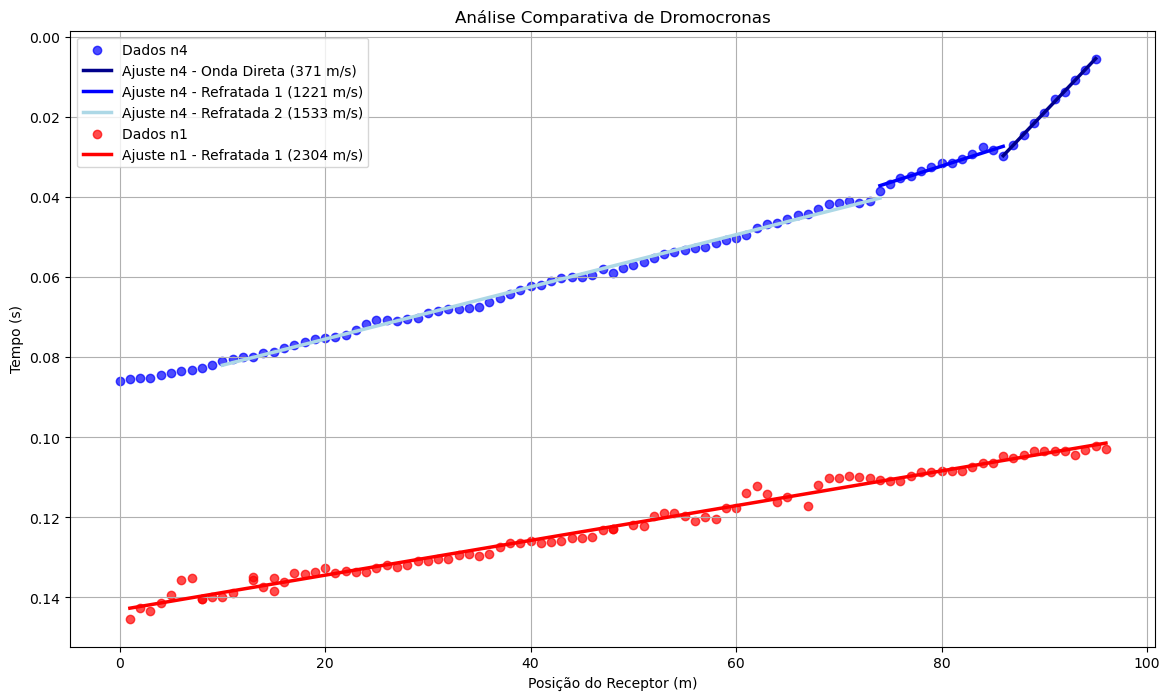

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure os dois tiros que você quer comparar)
# ==============================================================================

# Defina aqui os parâmetros para cada um dos dois tiros que serão analisados
analises = {
    'n4': {
        'arquivo': 'picks/n4',  # <--- Nome do primeiro arquivo
        'cor_dados': 'blue',
        'segmentos': {
            'Onda Direta': {'dist_min': 86, 'dist_max': 99999, 'cor': 'darkblue'},
            'Refratada 1': {'dist_min': 74, 'dist_max': 86, 'cor': 'blue'},
            'Refratada 2': {'dist_min': 10, 'dist_max': 74, 'cor': 'lightblue'}
        }
    },
    
    'n1': {
        'arquivo': 'picks/n1',  # <--- Nome do segundo arquivo
        'cor_dados': 'red',
        'segmentos': {
            'Onda Direta': {'dist_min': 0, 'dist_max': 0, 'cor': 'darkred'},
            'Refratada 1': {'dist_min': 0, 'dist_max': 99999, 'cor': 'red'},
            #'Refratada 2': {'dist_min': 10, 'dist_max': 74, 'cor': 'lightsalmon'}
        },
    
        
    }
}

# ==============================================================================


# --- Início da Análise e Plotagem ---
plt.figure(figsize=(14, 8))
ax = plt.gca()
print("--- Iniciando Análise Comparativa de Tiros ---")

# Loop principal para analisar cada tiro definido no painel de controle
for nome_tiro, config in analises.items():
    nome_arquivo = config['arquivo']
    segmentos_para_analise = config['segmentos']
    cor_dados = config['cor_dados']
    
    print(f"\n--- Analisando o '{nome_tiro}': {nome_arquivo} ---")
    
    # --- 1. Carregar e Limpar os Dados ---
    try:
        tempos_brutos, posicoes_brutas = np.loadtxt(nome_arquivo, unpack=True)
    except Exception as e:
        print(f"ERRO ao carregar o arquivo '{nome_arquivo}': {e}")
        continue # Pula para o próximo tiro

    indices_sorted = np.argsort(posicoes_brutas)
    posicoes = posicoes_brutas[indices_sorted]
    tempos = tempos_brutos[indices_sorted]
    
    # Plota os pontos de dados brutos deste tiro
    ax.scatter(posicoes, tempos, label=f'Dados {nome_tiro}', marker='o', alpha=0.7, c=cor_dados)

    # --- 2. Análise dos Segmentos ---
    for nome_segmento, limites in segmentos_para_analise.items():
        dist_min = limites['dist_min']
        dist_max = limites['dist_max']
        cor_reta = limites['cor']
        
        mascara = (posicoes >= dist_min) & (posicoes <= dist_max)
        pos_segmento = posicoes[mascara]
        t_segmento = tempos[mascara]
        
        if len(pos_segmento) < 2:
            print(f"AVISO: Segmento '{nome_segmento}' do '{nome_tiro}' tem pontos insuficientes.")
            continue
            
        inclinacao, intercepto = np.polyfit(pos_segmento, t_segmento, 1)
        velocidade = abs(1 / inclinacao)
        
        print(f"  -> Segmento '{nome_segmento}': Velocidade = {velocidade:.2f} m/s")
        
        # Plota a reta de ajuste do segmento no gráfico principal
        ax.plot(pos_segmento, inclinacao * pos_segmento + intercepto, '-', color=cor_reta, lw=2.5, 
                label=f'Ajuste {nome_tiro} - {nome_segmento} ({velocidade:.0f} m/s)')

# --- 3. Configuração Final do Gráfico ---
ax.set_xlabel('Posição do Receptor (m)')
ax.set_ylabel('Tempo (s)')
ax.set_title('Análise Comparativa de Dromocronas')
ax.legend()
ax.grid(True)
ax.invert_yaxis()

nome_figura = 'analise_comparativa.png'
plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
print(f"\nGráfico comparativo salvo como: {nome_figura}")

plt.show()

--- Iniciando Análise Comparativa de Tiros ---

--- Analisando o 'n1': picks/n1 ---
  -> Segmento 'Onda Direta': Velocidade = 4710.72 m/s
  -> Segmento 'Refratada 1': Velocidade = 2174.82 m/s
  -> Segmento 'Refratada 2': Velocidade = 2244.95 m/s

--- Analisando o 'n1b': picks/n1b ---
  -> Segmento 'Onda Direta': Velocidade = 1656.05 m/s
  -> Segmento 'Refratada 1': Velocidade = 7828.10 m/s

--- Analisando o 'n4': picks/n4 ---
  -> Segmento 'Onda Direta': Velocidade = 398.61 m/s
  -> Segmento 'Refratada 1': Velocidade = 1477.20 m/s

Gráfico comparativo salvo como: analise_comparativa.png


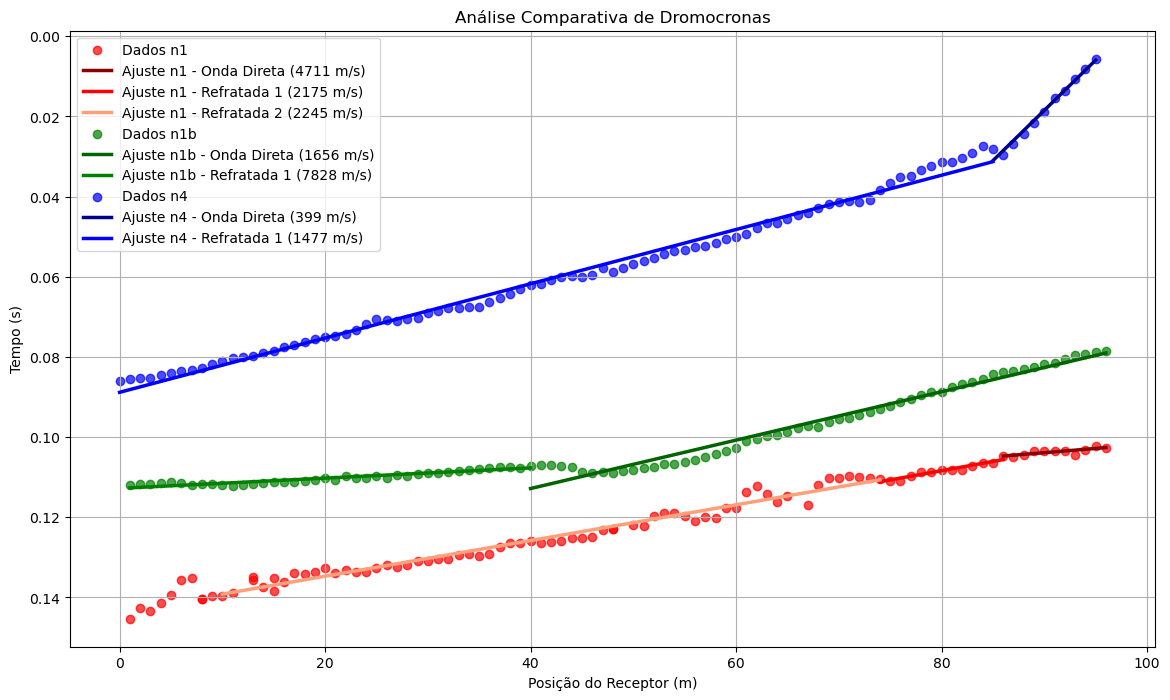

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure os dois tiros que você quer comparar)
# ==============================================================================

# Defina aqui os parâmetros para cada um dos dois tiros que serão analisados
analises = {
    'n1': {
        'arquivo': 'picks/n1',  # <--- Nome do primeiro arquivo
        'cor_dados': 'red',
        'segmentos': {
            'Onda Direta': {'dist_min': 86, 'dist_max': 99999, 'cor': 'darkred'},
            'Refratada 1': {'dist_min': 74, 'dist_max': 86, 'cor': 'red'},
            'Refratada 2': {'dist_min': 10, 'dist_max': 74, 'cor': 'lightsalmon'}
        }
    },
    
    'n1b': {
        'arquivo': 'picks/n1b',  # <--- Nome do segundo arquivo
        'cor_dados': 'green',
        'segmentos': {
            'Onda Direta': {'dist_min': 40, 'dist_max': 999999, 'cor': 'darkgreen'},
            'Refratada 1': {'dist_min': 0, 'dist_max': 40, 'cor': 'green'},
            #'Refratada 2': {'dist_min': 0, 'dist_max': 0, 'cor': 'lightgreen'},

        }
    },
        
    'n4': {
        'arquivo': 'picks/n4',  # <--- Nome do segundo arquivo
        'cor_dados': 'blue',
        'segmentos': {
            'Onda Direta': {'dist_min': 85, 'dist_max': 99999, 'cor': 'darkblue'},
            'Refratada 1': {'dist_min': 0, 'dist_max': 85, 'cor': 'blue'},
            #'Refratada 2': {'dist_min': 0, 'dist_max': 0, 'cor': 'lightblue'}, 

        }
    },
    
}
# ==============================================================================


# --- Início da Análise e Plotagem ---
plt.figure(figsize=(14, 8))
ax = plt.gca()
print("--- Iniciando Análise Comparativa de Tiros ---")

# Loop principal para analisar cada tiro definido no painel de controle
for nome_tiro, config in analises.items():
    nome_arquivo = config['arquivo']
    segmentos_para_analise = config['segmentos']
    cor_dados = config['cor_dados']
    
    print(f"\n--- Analisando o '{nome_tiro}': {nome_arquivo} ---")
    
    # --- 1. Carregar e Limpar os Dados ---
    try:
        tempos_brutos, posicoes_brutas = np.loadtxt(nome_arquivo, unpack=True)
    except Exception as e:
        print(f"ERRO ao carregar o arquivo '{nome_arquivo}': {e}")
        continue # Pula para o próximo tiro

    indices_sorted = np.argsort(posicoes_brutas)
    posicoes = posicoes_brutas[indices_sorted]
    tempos = tempos_brutos[indices_sorted]
    
    # Plota os pontos de dados brutos deste tiro
    ax.scatter(posicoes, tempos, label=f'Dados {nome_tiro}', marker='o', alpha=0.7, c=cor_dados)

    # --- 2. Análise dos Segmentos ---
    for nome_segmento, limites in segmentos_para_analise.items():
        dist_min = limites['dist_min']
        dist_max = limites['dist_max']
        cor_reta = limites['cor']
        
        mascara = (posicoes >= dist_min) & (posicoes <= dist_max)
        pos_segmento = posicoes[mascara]
        t_segmento = tempos[mascara]
        
        if len(pos_segmento) < 2:
            print(f"AVISO: Segmento '{nome_segmento}' do '{nome_tiro}' tem pontos insuficientes.")
            continue
            
        inclinacao, intercepto = np.polyfit(pos_segmento, t_segmento, 1)
        velocidade = abs(1 / inclinacao)
        
        print(f"  -> Segmento '{nome_segmento}': Velocidade = {velocidade:.2f} m/s")
        
        # Plota a reta de ajuste do segmento no gráfico principal
        ax.plot(pos_segmento, inclinacao * pos_segmento + intercepto, '-', color=cor_reta, lw=2.5, 
                label=f'Ajuste {nome_tiro} - {nome_segmento} ({velocidade:.0f} m/s)')

# --- 3. Configuração Final do Gráfico ---
ax.set_xlabel('Posição do Receptor (m)')
ax.set_ylabel('Tempo (s)')
ax.set_title('Análise Comparativa de Dromocronas')
ax.legend()
ax.grid(True)
ax.invert_yaxis()

nome_figura = 'analise_comparativa.png'
plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
print(f"\nGráfico comparativo salvo como: {nome_figura}")

plt.show()